<a href="https://colab.research.google.com/github/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/ANN_CourseWork_GoogLeNet_Rajaram_Kuberan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **7088 CEM - Artificial Neural Network Coursework**
##**Coventry University**
###**Student Name**: Rajaram Kuberan
###**Student ID**  : 10457647
###**Email ID**    : kuberanr@coventry.ac.uk

# **Topic: Image Classification of Grocery Items for Ketogenic Shopping Using CNN Architectures**

This project Worflow is carried out in five parts:

**1. Data Collection**

**2. Data Preprocessing**

**3. CNN Architecture Selection and Modelling**

**4. Image Classification and Prediction**

**5. Metrics Calculation**

There are two architectures used for this Coursework:

1. GoogLeNet Architecture
2. Transfer Learning

In this Colab Notebook, the first architecture is explained: GoogLeNet Architecture without Transfer Learning and with Transfer Learning. The second  architecture - Transfer Learning using MobileNet architecture is explained in another Colab Notebook - [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/Transfer_Learning.ipynb)

  GoogLeNet Architecture is used to perform Image Classification on Ketogenic and Non-Ketogenic Food items. The Keras Library is used to build the GoogLeNet CNN architecture. The training/test datas are pushed into the Github repository. 

Code Link for whole project - [Github link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ.git).

##**1. Data Collection**

  The dataset used for this project is not taken directly from Kaggle or UCI data reppsitory. We have novelly scrapped the images from the UK top supermarket webistes, and also added images from two projects where grocery images were used for performing Classification.




###**1.1 Image Scrapping**

  Data is collected by scrapping images from websites like [Tesco](https://www.tesco.com/groceries/) and [Morrisons](https://groceries.morrisons.com/browse). Additionally the dataset from [Grocery Dataset](https://github.com/marcusklasson/GroceryStoreDataset/tree/master/dataset) and [Freiburg Grocery Dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/) are also used. For Image Scrapping, Automation Tool - Selenium written in Java is used in this project. The Selenium with Python was also used. But Java Selenium combination helped us to scrap nearly 1500 images in a single exection of code. In this way, we could scrap nearly 12500+ images from Tesco website and 7500+ images from Morrisons website. The Grocery and Freiburg Dataset contains 5000 images respectively. So, totally we have 30000+ images to perform Classification.


###**1.2 Selenium Java code Link**

  Below are the Github link for selenium Java code:

Tesco Selenium Java codes - [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/Data_Image_Web_scrapping/tesco_selenium.java)

Morrisons Selenium Java - [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/Data_Image_Web_scrapping/Morrisons_Selenium.java)

Dependencies required to execute do Automated Image Scrapping: 
1. Chromedriver - [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/tree/main/Data_Image_Web_scrapping/chromedriver_win32)

2. Maven Repository and Selenium Ashot - [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/Data_Image_Web_scrapping/selenium_ashot.txt)

3. XML Pom file where the dependencies are listed to run the Java Selenium code: [Link](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/Data_Image_Web_scrapping/Automation/Images/pom.xml)

###**1.3 Importing Data from the Github**

Git clone is used to import the data from Github to Google Colab. The GPU runtime is used to run the CNN model due to its heavy computational dependencies.



In [1]:
!git clone https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ.git

Cloning into 'ANN_Coursework_Coventry_Univ'...
remote: Enumerating objects: 4761, done.
remote: Counting objects: 100% (4761/4761), done.
remote: Compressing objects: 100% (4728/4728), done.
remote: Total 30365 (delta 20), reused 4756 (delta 16), pack-reused 25604
Receiving objects: 100% (30365/30365), 6.12 GiB | 33.12 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (31423/31423), done.


##**2. Data Preprocessing**

In this worflow, the dataset of 30000+ images are splitted randomly in the ratio of 80:20.

The images are segregated, and stored in separate folders named train and test.

Splitting the data code Link: [Python Code](https://github.com/rajaramkuberan/ANN_Coursework_Coventry_Univ/blob/main/splitting_the_data.ipynb)

Now ,let's use ImageDataGenerator class to create our train and test dataset and normalize our data. 

It's important to normalize our data because data going into our CNN to improve its overall performance. We will use the rescale parameter to scale our image pixel values from [0, 255] to [0,1].

In each generator, we specify the source directory of our images, the classes, the input image size, the batch size (how many images to process at once), and class mode.




###**2.1 Importing the Necessary Libraries**

The necessary libraries are imported for performing Data Preprocessing and CNN Modelling.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score


###**2.2 Image Preprocessing**

In this process, ImageDataGenerator class is used to create our train and test dataset for binary classification.Moreover, data is also normalised.



####**2.2.1 Data/Image Normalisation**

It's important to normalize our data because most of the CNN architecture accepts images in particular pixel values to improve its overall performance. 

For this, the rescale parameter is used to scale our image pixel values from [0, 255] to [0,1].

In each generator, we specify the source directory of our images, the classes, the input image size, the batch size (how many images to process at once), and class mode.

In [3]:
# initialising the image size as 224x224
IMAGE_SIZE = [224,224]


# Setting the Path to test and train data 
test_path = '/content/ANN_Coursework_Coventry_Univ/test'
train_path = '/content/ANN_Coursework_Coventry_Univ/train'

In [4]:
# transforming train data images
train_datagen = ImageDataGenerator(rescale = 1/255)

# transforming train data images
test_datagen = ImageDataGenerator(rescale = 1/255)


In [5]:
#training data 
train_generator = train_datagen.flow_from_directory(
        '/content/ANN_Coursework_Coventry_Univ/train',  # This is the source directory for training images
        classes = ['Keto_train', 'Non_Keto_train'],
        target_size=(224, 224),  # All images are resized to 224x224
        batch_size=32,
        # Use binary labels
        class_mode='binary')

# testing data
test_generator = test_datagen.flow_from_directory(
        '/content/ANN_Coursework_Coventry_Univ/test',  # This is the source directory for test images
        classes = ['Keto_test', 'Non_Keto_Test'],
        target_size=(224, 224),  # All images are resized to 224x224
        batch_size=16,
        # Use binary labels
        class_mode='binary')

Found 24861 images belonging to 2 classes.
Found 6163 images belonging to 2 classes.


##**3. Building the Model**

In this project, GoogLeNet Architecture is used to perform Image Classification on Ketogenic and Non-Ketogenic Food items. The Keras Library is used to build the GoogLeNet CNN architecture. The training/test datas are pushed into the Github repository.

In GoogLeNet architecture, there ae 4 blocks of Inception layer. Firstly to avoid repeating the layers, create the inception block function so that we can use it in the model easily.

Reference: Szegedy, Christian, et al. “Going deeper with convolutions.” Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

The above 2015 Paper is used as the reference to create the blocks. The kernel size and the convolution layers are 
exactly written in Python using Keras Library as mentioned in the paper.

### **3.1 GoogLeNet Architecture**

####**3.1.1 Create the Inception Blocks**

In [6]:
# create an Inception block 
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  
  # 1st block:
  block1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)

  # 2nd block:
  block2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)
  block2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', 
                 activation = 'relu')(block2)

  # 3rd block:
  block3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(input_layer)
  block3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', 
                 activation = 'relu')(block3)

  # 4th block:
  block4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  block4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', 
                 activation = 'relu')(block4)

  output_layer = concatenate([block1, block2, block3, block4], axis = -1)

  return output_layer

#### **3.1.2 Create a GoogLenet Layer**
 Here we will define GoogLeNet Model Layers and then return the model.




In [7]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', 
             activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', 
             activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', 
             activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, 
                      f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, 
                      f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, 
                      f3_conv5 = 48, f4 = 64)

  # Average Pooling Layer 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', 
              activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, 
                      f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, 
                      f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, 
                      f3_conv5 = 64, f4 = 64)

  # Average Pooling Layer 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', 
              activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, 
                      f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

model = GoogLeNet()

#### **3.1.3 Model Summary**
The model.summary() method call prints a summary of the NN 

In [8]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 54, 54, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

####**3.1.4 Model Compiling/Execution**

The "output shape" column shows the transformation of the dimensions of each layer as a result of the convolution and max pooling - convolution will reduce the layer size by a bit due to padding, and max pooling will halve the output size.


Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss. We will use the Adam optimizer. Adam is a sensible optimization algorithm because it automates learning-rate tuning for us (alternatively, we could also use RmsProp and Adagrad for similar results). We will add accuracy to metrics so that the model will monitor accuracy during training

In [ ]:
#add loss function and optimisers
#model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])


In [9]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers

#model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=RMSprop(lr=0.001),
 #              metrics=['accuracy', tf.keras.metrics.AUC()])



model.compile(optimizer = 'Adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
#model.compile(optimizer=RMSprop(lr=0.01), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

####**3.1.5 Fitting the Model(Training)**
Let's train for 25 epochs GPU connection:


In [10]:
# epochs is 15  
google_fit_without_tl = model.fit(
      train_generator,
      steps_per_epoch=32,  
      epochs=25,
      verbose=1,
      validation_data = test_generator,
      validation_steps=16)

Epoch 1/25
32/32 [==============================] - 59s 709ms/step - loss: 8.7522 - dense_4_loss: 4.2917 - dense_1_loss: 1.0674 - dense_3_loss: 3.3931 - dense_4_accuracy: 0.4107 - dense_1_accuracy: 0.4932 - dense_3_accuracy: 0.4303 - val_loss: 1.9714 - val_dense_4_loss: 0.6536 - val_dense_1_loss: 0.6546 - val_dense_3_loss: 0.6631 - val_dense_4_accuracy: 0.6367 - val_dense_1_accuracy: 0.6367 - val_dense_3_accuracy: 0.6367
Epoch 2/25
32/32 [==============================] - 20s 627ms/step - loss: 2.0753 - dense_4_loss: 0.6761 - dense_1_loss: 0.6799 - dense_3_loss: 0.7193 - dense_4_accuracy: 0.6143 - dense_1_accuracy: 0.6256 - dense_3_accuracy: 0.5894 - val_loss: 2.0453 - val_dense_4_loss: 0.6828 - val_dense_1_loss: 0.6811 - val_dense_3_loss: 0.6814 - val_dense_4_accuracy: 0.5859 - val_dense_1_accuracy: 0.5859 - val_dense_3_accuracy: 0.5859
Epoch 3/25
32/32 [==============================] - 20s 612ms/step - loss: 2.0617 - dense_4_loss: 0.6942 - dense_1_loss: 0.6880 - dense_3_loss: 0.6794

###**3.2: Transfer Learning with GoogLeNet Architecture**

####**3.2.1 Creating Transfer Learning Architecture using GoogLenet Architecture**

In [42]:
model = Sequential()
model.add(InceptionV3(include_top = False, weights="imagenet", input_shape=(224, 224, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

87916544/87910968 [==============================] - 1s 0us/step


####**3.2.2 Model Compilation/Execution**

In [43]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
               optimizer=RMSprop(lr=0.001),
              metrics=['accuracy', tf.keras.metrics.AUC()])

####**3.2.3 Fitting the model**

In [44]:
Google_fit_with_tl = model.fit(
      train_generator,
      steps_per_epoch=32,  
      epochs=25,
      verbose=1,
      validation_data = test_generator,
      validation_steps=16)

Epoch 1/25
32/32 [==============================] - 22s 513ms/step - loss: 0.7724 - accuracy: 0.5779 - auc_3: 0.5560 - val_loss: 0.6732 - val_accuracy: 0.5703 - val_auc_3: 0.5775
Epoch 2/25
32/32 [==============================] - 14s 449ms/step - loss: 0.6893 - accuracy: 0.6060 - auc_3: 0.5793 - val_loss: 0.9183 - val_accuracy: 0.6211 - val_auc_3: 0.6229
Epoch 3/25
32/32 [==============================] - 15s 455ms/step - loss: 0.7188 - accuracy: 0.6040 - auc_3: 0.5808 - val_loss: 0.6675 - val_accuracy: 0.6641 - val_auc_3: 0.6485
Epoch 4/25
32/32 [==============================] - 16s 488ms/step - loss: 0.6449 - accuracy: 0.6460 - auc_3: 0.6228 - val_loss: 0.6314 - val_accuracy: 0.6289 - val_auc_3: 0.6664
Epoch 5/25
32/32 [==============================] - 14s 452ms/step - loss: 0.6914 - accuracy: 0.5911 - auc_3: 0.5961 - val_loss: 0.6518 - val_accuracy: 0.6758 - val_auc_3: 0.6124
Epoch 6/25
32/32 [==============================] - 15s 454ms/step - loss: 0.6198 - accuracy: 0.6656 - au

###**4. Image Classification and Prediction**

In [45]:
model.evaluate(test_generator)

386/386 [==============================] - 66s 170ms/step - loss: 0.5945 - accuracy: 0.6813 - auc_3: 0.7235


[0.5944951176643372, 0.6813240051269531, 0.7235076427459717]

In [46]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator, 
                      verbose=1)

386/386 [==============================] - 65s 166ms/step


In [47]:
print(len(test_generator.classes))

6163


###**5. Metrics Calculation**

Now, calculating the ROC curve and plot it.

First, let's make predictions on our test set. When using generators to make predictions, we must first turn off shuffle (as we did when we created validation_generator) and reset the generator:

In [48]:
fpr, tpr, threshold = metrics.roc_curve(test_generator.classes, preds )

In [49]:
roc_auc = metrics.auc(fpr, tpr)

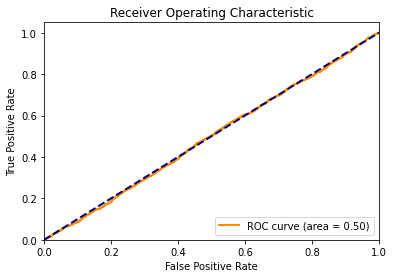

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()